In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import numpy as np

#### Setting up

In [44]:
base_dir = os.path.abspath('../data/processed')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

IMG_SIZE = 150  # We force all images to this squared size (150x150)
BATCH_SIZE = 32 # We feed 32 images at a time to the model

print(f"Training on data from: {train_dir}")
print(f"Validating on data from: {val_dir}")

Training on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/train
Validating on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/val


### Generators definition for proper training and evaluation

In [45]:
# Train with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values (0-1)
    rotation_range=40,      # Twist up to 40 degrees
    width_shift_range=0.2,  # Move Left/Right 20%
    height_shift_range=0.2, # Move Up/Down 20%
    shear_range=0.2,        # Slant/Perspective distortion
    zoom_range=0.2,         # Zoom in/out 20%
    horizontal_flip=True,   # Mirror flip
    fill_mode='nearest'     # Fill gaps with neighbor color
)

# Validation (No augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data...")
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Loading Training Data...
Found 1531 images belonging to 3 classes.
Loading Validation Data...
Found 326 images belonging to 3 classes.


## Model 2: Deep CNN

**Hypothesis:** Our Baseline Model (Model 1) achieved >98% accuracy using only 2 convolutional blocks. Because the Rock-Paper-Scissors dataset consists of relatively simple, centered shapes on a uniform green background, we hypothesize that the dataset has a low intrinsic dimensionality. 

**Experiment:**
We will build a deep, 4-block CNN with a massive 512-neuron Dense layer


In [46]:
# Define the Complex, Unregularized Architecture
model = models.Sequential(name="Deep_CNN")

# Explicit Input Layer
model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

# Block 1
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Block 2
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Block 3
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Block 4
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Classifier Head
model.add(layers.Flatten())

# Big Dense Layer (512 units)
model.add(layers.Dense(512, activation='relu'))

# Output Layer
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "Deep_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,007,299 (41.99 MB)

 Trainable params: 11,007,299 (41.99 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile the model using cross-entropy, adam as optimizer and accuracy to evaluate

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Deep CNN: Ready for Training.")

Deep CNN: Ready for Training.


##### Early stopping (Relaxed) and Reduce LR on Plateau

here we apply a larger patience for early stopping

In [48]:
# Relaxed Early Stopping to let the model overfit enough to visualize it on the plot
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,           # Increased patience to watch the validation loss spike
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

#### Training

In [49]:
print("Starting training of Deep CNN ...")

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")

Starting training of Deep CNN ...
Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - accuracy: 0.4389 - loss: 1.0602 - val_accuracy: 0.6104 - val_loss: 0.8993 - learning_rate: 0.0010
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.6924 - loss: 0.7334 - val_accuracy: 0.9233 - val_loss: 0.2303 - learning_rate: 0.0010
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.8576 - loss: 0.3814 - val_accuracy: 0.9847 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 392ms/step - accuracy: 0.8935 - loss: 0.2905 - val_accuracy: 0.9785 - val_loss: 0.0871 - learning_rate: 0.0010
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.9406 - loss: 0.1881 - val_accuracy: 0.9693 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.9556 - loss: 0.1457 - val_accuracy: 0.9877 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 403ms/

In [50]:
# Define where to save the model
os.makedirs('../models', exist_ok=True)
save_path = os.path.abspath('../models/deep_model.keras')

# Save the entire model
model.save(save_path)

print(f"Model saved successfully at: {save_path}")

Model saved successfully at: /Users/paolominini/Projects/rps-cnn-classifier/models/deep_model.keras


#### Plot the results

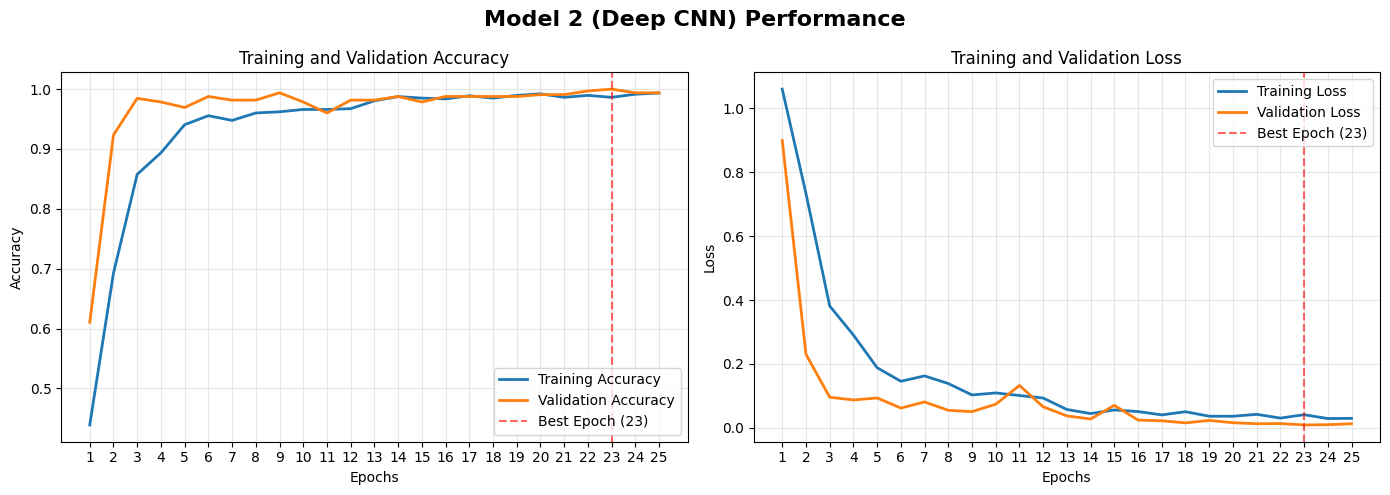

Best model was restored from Epoch 23 (Lowest Val Loss: 0.0090)


In [55]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Find best epoch for vertical line
best_epoch = val_loss.index(min(val_loss)) + 1

plt.figure(figsize=(14, 5))

# Plot Accuracy (Notice the gap!)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.6, label=f'Best Epoch ({best_epoch})')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot Loss (Watch the orange line go UP while blue goes DOWN)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.6, label=f'Best Epoch ({best_epoch})')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.suptitle('Model 2 (Deep CNN) Performance', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
os.makedirs('../reports/figures', exist_ok=True)
plt.savefig(os.path.abspath('../reports/figures/training_history_deep.png'))

plt.show()

print(f"Best model was restored from Epoch {best_epoch} (Lowest Val Loss: {min(val_loss):.4f})")

### Model 2 Analysis: The "Unregularized Deep" CNN
**1. Architecture Design and training:**
We escalated complexity by constructing a deep CNN with 4 Convolutional Blocks (32, 64, 128, and 256 filters) followed by a massive 512-neuron Dense layer. This architecture was explicitly designed to test the network's capacity limits by intentionally omitting explicit regularization techniques (such as Dropout). The training was implemented for up to 25 epochs using a relaxed Early Stopping (patience = 8) to allow potential overfitting to manifest, alongside ReduceLROnPlateau (patience = 3).

**2. Performance & Observations:**
Contrary to our hypothesis that this high-capacity network would severely overfit the training data, the model achieved **perfect validation accuracy (~100%)** and extremely low validation loss (0.0091).


**3. Scientific Interpretation:**
The results of this experiment provide critical insights into model capacity versus task complexity for this specific dataset.

- Over-parameterization: Because the dataset features a clean background and distinct shapes, this 4-block architecture might be computationally wasteful.

- Risk of Brittleness: While it scored perfectly on the clean validation set, such an unregularized, high-capacity model is highly susceptible to "domain shift" and may fail on out-of-distribution data.

**Conclusion:**
While Model 2 perfectly maps the dataset, it proves that arbitrarily adding layers and neurons is an inefficient strategy. We will now proceed to **Model 3 (The Tuned CNN)**, utilizing the Hyperband algorithm to mathematically search for the optimal balance: minimizing computational complexity while maximizing robustness through automated Dropout tuning.

### Mistakes Check: no mistakes maked on the validation set

In [53]:
# audit generator.
# We need this to match filenames to predictions 1-to-1
audit_datagen = ImageDataGenerator(rescale=1./255)
audit_generator = audit_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # the one thing different from the usual train and val_generators (in order to allow to recover the correct image)
)

# get predictions
print("Predicting on Validation Set...")
predictions = model.predict(audit_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = audit_generator.classes
class_labels = list(audit_generator.class_indices.keys()) # ['paper', 'rock', 'scissors']

# find errors
# Get the indices where Prediction doesn't match the true value
errors = np.where(predicted_classes != true_classes)[0]
print(f"Total Errors: {len(errors)} out of {len(true_classes)} images")

# plot the mistakes
if len(errors) > 0:
    plt.figure(figsize=(15, 10))
    
    # We will show up to 10 errors
    num_to_show = min(10, len(errors))
    
    for i in range(num_to_show):
        error_index = errors[i]
        
        # Get the actual image file path
        image_path = audit_generator.filepaths[error_index]
        
        # Load and plot
        img = plt.imread(image_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        
        # Title: "Pred: Rock / True: Paper"
        pred_label = class_labels[predicted_classes[error_index]]
        true_label = class_labels[true_classes[error_index]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.abspath('../reports/figures/mistakes_deep.png'))
    plt.show()
else:
    print("The model made zero mistakes on the validation set.")

Found 326 images belonging to 3 classes.
Predicting on Validation Set...
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Total Errors: 0 out of 326 images
The model made zero mistakes on the validation set.
